In [2]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [46]:
def load_labels(labels_path='models/cfg/coco.names'):
    # Load the COCO class names
    with open(labels_path, 'r') as f:
        class_names = f.read().strip().split('\n')

    # Get a different colors for each of the classes
    np.random.seed(42)
    colors = np.random.randint(
        0, 255,
        size=(len(class_names), 3),
        dtype='uint8')

    return class_names, colors

def load_model(model_path='models/yolov4.weights', cfg_path='models/cfg/yolov4.cfg'):
    net = cv2.dnn.readNet(
        model=model_path,
        config=cfg_path)

    return net

def show_img(img):
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def reshape_img(img, max_width=600):
    if img.shape[1] > max_width:
        img = cv2.resize(
            img,
            (
                max_width,
                int(img.shape[0] * max_width / img.shape[1]
                    )
            )
        )
    return img

def load_image(img_path):
    image = cv2.imread(img_path)
    image = reshape_img(image)
    return image, image.shape[:2]

def blob_image(net, image):
    start = time.time()

    ln = net.getLayerNames()
    ln = [ln[ii[0] - 1] for ii in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(
        image,
        1 / 255.0,
        size=(416, 416),
        swapRB=True,
        crop=False
    )

    net.setInput(blob)
    layer_outputs = net.forward(ln)
    end = time.time()

    fps = f'{end - start:.2f}'

    return net, layer_outputs, fps

def detections(detection, boxes, confidences, class_ids, H, W, threshold=0.5):

    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    
    if confidence > threshold:
        box = detection[0:4] * np.array([W, H, W, H])
        (centerX, centerY, width, height) = box.astype('int')
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))

        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
        class_ids.append(class_id)

    return boxes, confidences, class_ids

def nms_objects(boxes, confidences, threshold=0.5, threshold_nms=0.3):
    objects = cv2.dnn.NMSBoxes(boxes, confidences, threshold, threshold_nms)
    return objects

def draw_bounding_boxes(objects, image, boxes, confidences, class_ids, class_names, colors):
    if len(objects) > 0:
        for ii in objects.flatten():
            (x, y) = (boxes[ii][0], boxes[ii][1])
            (w, h) = (boxes[ii][2], boxes[ii][3])
            color = [int(c) for c in colors[class_ids[ii]]]

            cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
            text = f'{class_names[class_ids[ii]]}: {confidences[ii]:.2f}'
            cv2.putText(image, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # TODO: Save detections for specifc class
            # detection = image_cp[y:y+h, x:x+w]

        return image
    else:
        print('No detections')
        return None


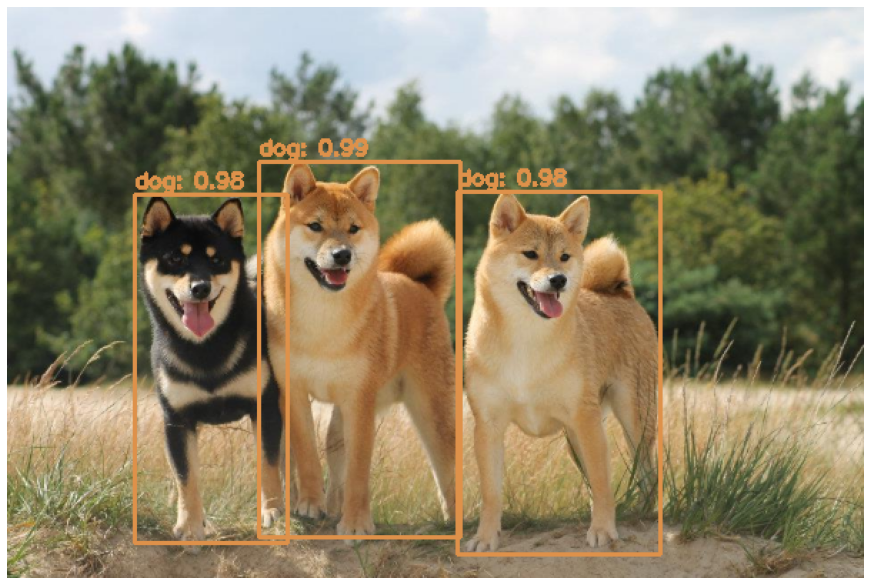

In [52]:
class_names, colors = load_labels()
net = load_model()

image, (H, W) = load_image('images/dogs.jpg')
image_cp = image.copy()
net, layer_outputs, fps = blob_image(net, image)

boxes = []
confidences = []
class_ids = []
for output in layer_outputs:
    for detection in output:
        boxes, confidences, class_ids = detections(
            detection, boxes, confidences, class_ids, H, W, threshold=0.5)
        objects = nms_objects(boxes, confidences, threshold=0.5, threshold_nms=0.3)

image = draw_bounding_boxes(objects, image, boxes, confidences, class_ids, class_names, colors)
show_img(image)